In [1]:
import os
import pandas as pd
import numpy as np
import re
import json
import requests
import time
import seaborn as sns
from datetime import datetime
from bs4 import BeautifulSoup

In [2]:
def outliers_iqr(data):
    """ Функция для поиска выбросов """
    quartile_1, quartile_3 = np.percentile(data, [25,75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return [lower_bound, upper_bound]

In [3]:
df = pd.read_csv('data\main_task.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


В датасете только три признака представлены типом float64. Семь признаков типа object. Три признака содержат пропуски.

In [5]:
#Для удобства работы с датасетом, приведём навзвания колонок к нижнему регистру и заменим пробел на подчеркивание
def rename_col(name):
    return name.lower().replace(' ', '_')    

df.columns = [rename_col(x) for x in df.columns]

In [6]:
df.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
       'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta'],
      dtype='object')

In [7]:
print('Всего {}% строк без пропущенных значений'.format(round(df.dropna().shape[0] / df.shape[0]*100),1))

Всего 64% строк без пропущенных значений


Так как в датасете есть признаки, где отсутствует значительная часть данных, принято решение дополнить эти данные, а так же получить новые признаки с сайта tripadvisor.com по ссылкам датасета. 

Задача осложняется тем, что на обработку 40000 страниц уйдёт более 16 часов.

Таким образом, надо собрать информацию за один проход.

Принято решение загрузить часть raw данных, а далее уже обработать на месте (так как повторно выкачивать - трудоёмко).

Данные будут сохранены в отдельный файл


In [8]:
# Ремарка: учитывая объем получившегося файла (165Мб), возможно стоило на лету выдернуть только нужные на тот момент данные.

Сформируем слудующую структуру raw данных, которые возьмём с сайта

data
- rating (рейтинг)
- price_range (диапазон цен)
- review_date (даты последних отзывов)
- review_num (количество отзывов)
- data_google (геоданные и доп. информация)
- dist_near (расстояние до ближайшего важного объекта. Один из пунктов в data_google, но проще взять готовый с сайта).
- all_rest (количество всех ресторанов в городе)

In [9]:
url_server = 'https://www.tripadvisor.com'

In [10]:
def download_data(url_string):
    """ Функция парсинга данных с сайта https://www.tripadvisor.com """
    url = url_server + url_string
    try:
        print(url)
        html = requests.get(url)
    except:
        return None

    if html.status_code == 200:
        soup = BeautifulSoup (html.text, 'html.parser')
        rating = soup.findAll('span', class_='_3KcXyP0F')
        price_range = soup.findAll('a', class_='_2mn01bsa')
        review_date = soup.findAll('span', class_='ratingDate')    
        review_num = soup.findAll('span', class_='_3Wub8auF')
        data_google = soup.findAll('div', class_='xAOpeG9l _1KJtHjfU')
        dist_near = soup.findAll('span', class_='_2saB_OSe _1OBMr94N')
        all_rest = soup.findAll('span', class_='_13OzAOXO _2VxaSjVD')
        return {
            'rating': str(rating), 'price_range': str(price_range), 'review_date': str(review_date), 'review_num': str(review_num),
            'data_google': str(data_google), 'dist_near': str(dist_near), 'all_rest': str(all_rest)
               }
    else:
        return None

In [11]:
# Если данные есть на диске, загружаем из файла. Иначе выкачиваем (1 попытка с дропбокса, готовый вариант, 2. Повторный парсинг).
# Так как процедура парсинга длительная, добавил флаг. Если не разрешаем повторный парсинг сайта tripadvisor.com, значение - 0, иначе - 1
download = 0
try:
    # Если данные на диске
    if os.path.isfile('data/raw_data.json'):
        with open('data/raw_data.json', 'r') as f:
            raw_data = json.load(f)
    else:
        # Гит не позволил сразу залить файл размером более 100 мб. Быстрым решением оказалось залить на сторонний ресурс. ToDo: переместить на шару github
        # Пробуем с дропбокса
        response = requests.get('https://www.dropbox.com/s/1pe5zm2dy3l5fgd/raw_data.json?dl=1')
        data = response.text
        # Десериализуем
        raw_data = json.loads(data)
        # Сохраняем, чтобы повторно не выкачивать
        with open('data/raw_data.json', 'w') as write_f:
            write_f.write(data)
        
except:
    if download:
        # Загружаем данные с сайта (dict), где ключём является id_ta
        print('Try download data')

        # Данные сложим в словарь
        raw_data = dict()

        # Счетчик обработанных данных
        count = 0
        for id_ta in df.id_ta:
            count += 1
            # словарь для 
            res_dict = dict()
            # по текущему id_ta получаем ссылку
            url_string = df[df.id_ta == id_ta].url_ta.iloc[0]
            # отправляем ссылку для скачивания и парсинга данных
            data = download_data(url_string)

            # полученные данные фиксируем в словаре raw_data
            if data:
                res_dict['url_string'] = str(url_string)
                res_dict['data'] = data
                raw_data[id_ta] = res_dict

                # Небольшая перестраховка, сохраняем в файл данные, через каждые 100 записей
                if count % 100 == 0:
                    print(count)
                    with open('data/raw_data.json', 'w') as file:
                        json.dump(raw_data, file)
            time.sleep(0.5)

        with open('data/raw_data.json', 'w') as file:
            json.dump(raw_data, file)

In [12]:
len(raw_data)

39980

In [13]:
# Настораживает количество < 40000. Рассмотрим признак id_ta.

### id_ta — идентификатор ресторана в базе данных TripAdvisor.

In [14]:
df.id_ta.value_counts()

d11674463    2
d987900      2
d9802625     2
d7337366     2
d697406      2
            ..
d8090662     1
d8078237     1
d7159753     1
d1035708     1
d8396725     1
Name: id_ta, Length: 39980, dtype: int64

In [15]:
df[df.id_ta == 'd8753348']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
13942,id_1103,Madrid,['Spanish'],1104.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348
31238,id_1212,Madrid,['Spanish'],1213.0,4.5,$$ - $$$,73.0,"[['ok for beer, not for dinner'], ['12/20/2017']]",/Restaurant_Review-g187514-d8753348-Reviews-Tr...,d8753348


In [16]:
# Похоже, что есть не значительные ошибки в данных этого признака. Удаляем дубликаты.

In [17]:
df = df.drop_duplicates(subset = ['id_ta']) 

#### restaurant_id — идентификационный номер ресторана / сети ресторанов;

In [18]:
# Посмотрим на значения этого признака
df.restaurant_id.value_counts()

id_227      18
id_633      18
id_871      18
id_436      18
id_71       17
            ..
id_15453     1
id_16239     1
id_16379     1
id_7372      1
id_12216     1
Name: restaurant_id, Length: 11907, dtype: int64

In [19]:
df[df.restaurant_id == 'id_436'].head(5)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
2955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,4.5,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613
4674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,4.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362
6118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,4.5,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122
6215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,4.5,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365
7377,id_436,Luxembourg,['Asian'],437.0,4.5,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888


Рестораны одной сети имеют одинакоый restaurant_id, но разный id_ta

Можно сформировать новый признак - количество ресторанов одной сети.
Есть вероятность, что сетевые рестораны более известные и могут пользоваться большей популярностью.

Но попытки выделить этот признак лишь ухудшали результат.

In [20]:
# counts_rest = dict(df.restaurant_id.value_counts())
# df['network'] = df.restaurant_id.apply(lambda x: counts_rest[x])

# Как вариант, группировка
# df['network'] = df['network'].apply(lambda x: 0 if x<6 else 1 if x<12 else 2)

#### city — город, в котором находится ресторан;

In [21]:
df.city.value_counts()

London        5757
Paris         4897
Madrid        3088
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

In [22]:
len(df.city.value_counts())

31

In [23]:
# 31 город представлены в данном датасете

Добавим новые признаки - страны и население

In [24]:
# Загружаем данные (страны) по нужным городам. Eсли файл отсутствует, формируем данные из интернета.
# Ремарка. При поиске, попались несколько готовых датасетов, но их очистка занимает больше времени, чем парсинг
try:
    # Файл, сформированый кодом ниже. Если он отсутствует, то сайт парсится снова
    with open('data/cities.csv', 'r') as f:
        cities = json.load(f)
except:
    # Залить данные с сервиса geonames.org
    cities = dict()
    # Шаблон для парсинга данных в поиске страны
    countries_tmpl = re.compile('countries\/([\w|-]+)\/([\w-]+).html\"\>([\w\s\-]+)\<\/a\>')
    # Шаблон для парсинга данных в поиске населения
    population_tmpl = re.compile('population\s([\d\,]+)<\/small\>')
    # Выбираем нужные города из нашего датасета
    cities_from_df = [city for city in df.city.unique()]
    
    for city in cities_from_df:
        url = 'https://www.geonames.org/search.html?q={}&country='.format(city)
        try:
            html = requests.get(url)
            country = None
            population = None
            # Если ответ успешный, парсим данные
            if html.status_code == 200:
                soup = BeautifulSoup (html.text, 'html.parser')
                # Парсим таблицу с результатом, выбираем первое совпадение (наиболее релевантное)
                match = re.search(countries_tmpl, str(soup.findAll('table', {"class": "restable"})))
                if match:
                    # Сохраняем в формате ('GB', 'united-kingdom', 'United Kingdom')
                    country = match.groups()
                    
                    # Определяем население
                    match = re.search(population_tmpl, str(soup.findAll('table', {"class": "restable"})))
                    if match:
                        population = int(match.group(1).replace(',', ''))
                
                    # Итоговые данные заносим в словарь
                cities[city] = {'country': country, 'population': population}
        except:
            print('Error')
        
        # Чтобы не досить сервер, делаем маленькую паузу
        time.sleep(0.5)

    # Результат сохраняем, чтобы не дёргать ресурс повторно
    try:
        with open('data\cities.csv', 'w') as write_f:
            json.dump(cities, write_f)
    except:
        print('Error writing to file')

In [25]:
# Формируем новый признак - страны
def get_country(city):
    """ Функция принимает на вход город, возвращает страну """
    if city in cities:
        return cities[city]['country'][2]
    else:
        return None
        
df['country'] = df.city.apply(get_country)


In [26]:
# Формируем новый признак - население
def get_population(city):
    """ Функция принимает на вход город, возвращает количество проживающих человек """
    if city in cities:
        return cities[city]['population']
    else:
        return None
        
df['population'] = df.city.apply(get_population)

In [27]:
# Формируем новый признак capital (0 - нет, 1 - да)
capitals = dict()
with open('data\concap.csv', 'r') as cap_f:
    for line in cap_f.readlines():
        data_cap = line.split(',')
        # Город: Страна
        capitals[data_cap[1]] = data_cap[0]

In [28]:
df['capital'] = df.city.apply(lambda x: 1 if x in capitals else 0)

In [29]:
df['capital'].value_counts()

1    29808
0    10172
Name: capital, dtype: int64

In [30]:
# Сами города позже преобразуем в dummy переменные

#### cuisine_style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

In [31]:
print('Всего {}% строк без пропущенных значений'.format(round(df.cuisine_style.dropna().shape[0] / df.cuisine_style.shape[0]*100),1))

Всего 77% строк без пропущенных значений


In [32]:
# Дополняем данные (с сайта)

In [33]:
rest_tmpl = re.compile('html\W{2}(\w+)')

In [34]:
def update_cuisines(id_ta):
    """ Функция парсинга списка кухонь с сайта (закаченных ранее) """
    if id_ta in raw_data:
        match = re.findall(rest_tmpl, raw_data[id_ta]['data']['price_range'])
        if len(match) > 0:
            return(str(match))
    # Возвращаем Other, если и на сайте не указанно данных
    return str(['Other'])

In [35]:
# Обновить NaN из полученных данных
df['cuisine_style'] = df.apply(lambda x: update_cuisines(x['id_ta']) if pd.isnull(x['cuisine_style']) else x['cuisine_style'], 1)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      39980 non-null  object 
 1   city               39980 non-null  object 
 2   cuisine_style      39980 non-null  object 
 3   ranking            39980 non-null  float64
 4   rating             39980 non-null  float64
 5   price_range        26101 non-null  object 
 6   number_of_reviews  37437 non-null  float64
 7   reviews            39980 non-null  object 
 8   url_ta             39980 non-null  object 
 9   id_ta              39980 non-null  object 
 10  country            39980 non-null  object 
 11  population         39980 non-null  int64  
 12  capital            39980 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 4.3+ MB


Конвертируем перечень в список, для удобства работы

In [37]:
def cuisines_to_list(cusines_s):
    """ Конвертирует str в список cusines"""
    return [cuisine.strip()[1:-1] for cuisine in cusines_s[1:-1].split(',')]

In [38]:
# Заменяем кухни на список для удобства обработки
df['cuisine_list'] = df['cuisine_style'].dropna().apply(cuisines_to_list)

In [39]:
# Узнаем, какое количество представлено в датасете
# С учётом обновленных данных, список подрос (был 126)
cuisines_set = set()
for cuisines in df['cuisine_list'].dropna():
    for cuisine in cuisines:
        cuisines_set.add(cuisine)
len(cuisines_set)

160

Посмотрим, какая кухня представлена в наибольшем количестве ресторанов

In [40]:
# Словарь для подсчета ресторанов используемых кухонь
cuisines_dict = {x: 0 for x in cuisines_set}

for cuisines in df['cuisine_list'].dropna():
    for cuisine in cuisines:
        cuisines_dict[cuisine] += 1

print(max(cuisines_dict, key=lambda k: cuisines_dict[k]))

Vegetarian Friendly


In [41]:
# Сформируем новый признак - количество кухонь, предлагаемых в ресторане
df['cuisine_num'] = df['cuisine_list'].apply(lambda x: len(x))

In [42]:
# Как и предпологалось, cuisine_style, cuisine_list и cuisine_num не содержат пропусков
df.isnull().any()

restaurant_id        False
city                 False
cuisine_style        False
ranking              False
rating               False
price_range           True
number_of_reviews     True
reviews              False
url_ta               False
id_ta                False
country              False
population           False
capital              False
cuisine_list         False
cuisine_num          False
dtype: bool

<AxesSubplot:>

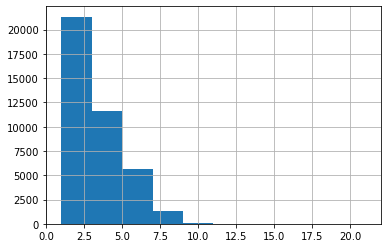

In [43]:
# Для нас важен признак cuisine_num, так как будет учавствовать в прогнозе
df.cuisine_num.hist()

In [44]:
df.cuisine_num.mean()

2.733166583291646

In [45]:
# Похоже есть выбросы. Чаще, на ресторан приходится около 3 видов кухонь

<AxesSubplot:xlabel='cuisine_num'>

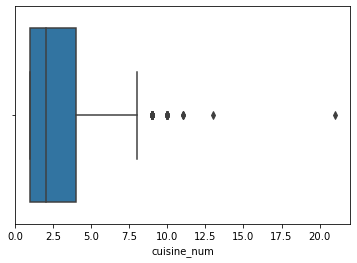

In [46]:
sns.boxplot(df.cuisine_num)

In [47]:
# Попытка убрать выбросы ухудшила прогноз 
# df = df[df.cuisine_num < outliers_iqr(df.cuisine_num)[1]]
# df.cuisine_num.hist(bins=30)

#### ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

In [48]:
# ranking не содержит пропусков

<AxesSubplot:>

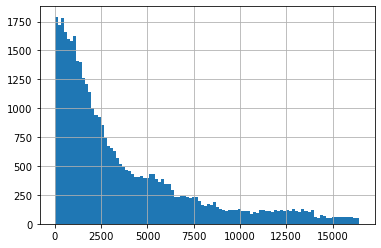

In [49]:
df.ranking.hist(bins=100)

In [50]:
# Очень популярная оценка до 2000-2500

<AxesSubplot:xlabel='ranking'>

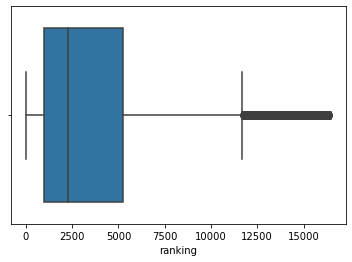

In [51]:
sns.boxplot(df.ranking)

In [52]:
# По данному признаку однозначного решения пока принять нельзя. Его модификация сильно влияет на прогноз (пока что, в сторону ухудшения)

#### rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

In [53]:
# Целевая переменная

In [54]:
# Основная часть оценок 4 - 4.5
df.rating.value_counts()

4.0    13684
4.5    10924
3.5     6821
5.0     3875
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

<AxesSubplot:>

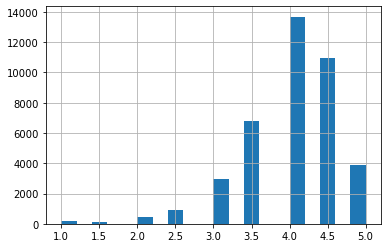

In [55]:
df.rating.hist(bins=20)

In [56]:
# Самый популярный рейтинг 4 и 4,5

#### price_range — диапазон цен в ресторане;

In [57]:
df['price_range'].value_counts(dropna=False)

$$ - $$$    18402
NaN         13879
$            6276
$$$$         1423
Name: price_range, dtype: int64

In [58]:
print('Всего {}% строк без пропущенных значений'.format(round(df.price_range.dropna().shape[0] / df.price_range.shape[0]*100),1))

Всего 65% строк без пропущенных значений


In [59]:
# Очень много пропусков. Заплоняем их данными с сайта

In [60]:
# Шаблон для парсинга данных о диапазоне цен
price_range_tmpl = re.compile('html\"\>([$|\s|-]*)\<\/a\>')

In [61]:
def update_price_range(id_ta):
    """ Функция возвращает диапазон цен (из парсинга данных сайта) """
    if id_ta in raw_data:
        match = re.search(price_range_tmpl, raw_data[id_ta]['data']['price_range'])
        if match:
            return match.group(1)
    return None

In [62]:
# Обновить полностью price range
#df['price_range_upd'] = df.apply(lambda x: update_price_range(x['ID_TA']), 1)

In [63]:
# Обновить только не достающие значения
df['price_range'] = df.apply(lambda x: update_price_range(x['id_ta']) if pd.isnull(x['price_range']) else x['price_range'], 1)

In [64]:
# Данный признак можно привести к числовому виду, для использования в прогнозе
price_dict = {
    '$': 0,
    '$$ - $$$': 1,
    '$$$$': 2
}
df['price_range_upd']= df['price_range'].replace(to_replace=price_dict)


In [65]:
df.price_range_upd.value_counts(dropna=False)

1.0    22022
0.0     8958
NaN     7453
2.0     1547
Name: price_range_upd, dtype: int64

In [66]:
print('Всего {}% строк без пропущенных значений'.format(round(df.price_range.dropna().shape[0] / df.price_range.shape[0]*100),1))

Всего 81% строк без пропущенных значений


In [67]:
# Пропусков заметно меньше, но всё равно они есть. Попробуем заполнить наиболее популярным значением - 1 ($$ - $$$) , то есть медиана

In [68]:
df['price_range_upd'] = df['price_range_upd'].fillna(1)

<AxesSubplot:>

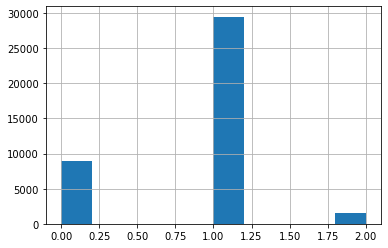

In [69]:
df.price_range_upd.hist()

### number_of_reviews — количество отзывов о ресторане;

In [70]:
df.number_of_reviews.value_counts(dropna=False)

NaN       2543
2.0       1915
3.0       1636
4.0       1370
5.0       1181
          ... 
2123.0       1
1633.0       1
1480.0       1
1924.0       1
1383.0       1
Name: number_of_reviews, Length: 1460, dtype: int64

In [71]:
print('Всего {}% строк без пропущенных значений'.format(round(df.number_of_reviews.dropna().shape[0] / df.number_of_reviews.shape[0]*100),1))

Всего 94% строк без пропущенных значений


In [72]:
# Попробуем обновить все данные свежими значениями.

In [73]:
review_num_tmpl = re.compile('>(\d+)<')

In [74]:
def update_reviews_num(id_ta):
    """ Возвращает количество отзывов с сайта """
    if id_ta in raw_data:
        match = re.search(review_num_tmpl, raw_data[id_ta]['data']['review_num'])
        if match:
            return int(match.group(1))
    # Если на сайте нет данных заполняем из датасета
    return df[df.id_ta == id_ta]['number_of_reviews'].iloc[0]

In [75]:
df['reviews_num_upd'] = df.apply(lambda x: update_reviews_num(x['id_ta']), 1)

In [76]:
df.reviews_num_upd.isna().any()

True

In [77]:
# Пропуски всё ещё есть. Если данных по отзывам нет, то скорее всего - молодые рестораны. Заменим пустые значения на 0

In [78]:
df.reviews_num_upd = df.reviews_num_upd.fillna(0)

<AxesSubplot:>

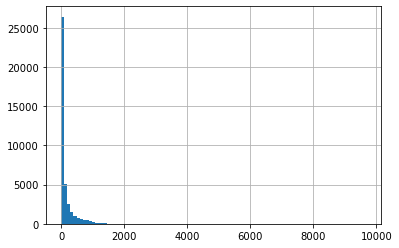

In [79]:
df.reviews_num_upd.hist(bins=100)

<AxesSubplot:xlabel='reviews_num_upd'>

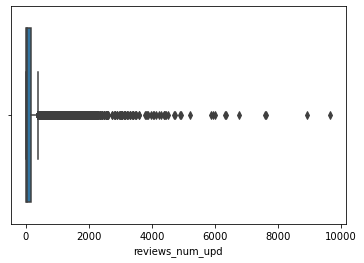

In [80]:
sns.boxplot(df.reviews_num_upd)

In [81]:
# Жуткие выбросы

In [82]:
outliers_iqr(df.reviews_num_upd)

[-202.5, 369.5]

In [83]:
# Если отсеять данные, то потеряем 4,5 записей. Довольно много.
len(df[df.reviews_num_upd > 367])

4598

In [84]:
# Попытка убрать выбросы ухудшила прогноз
# df = df[df.reviews_num_upd < 367]
# df.reviews_num_upd.hist()

#### reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

In [85]:
df.reviews.value_counts()

[[], []]                                                                                                                      6465
[['Simple, clean and stylish', 'Nice'], ['07/01/2017', '09/10/2017']]                                                            1
[['Lightning fast, but not good.'], ['05/02/2017']]                                                                              1
[['Excellent japanese', 'Quality Japanese'], ['11/17/2017', '10/15/2017']]                                                       1
[['A glimpse of Greek hospitality and cuisine', 'A Friendly Atmosphere'], ['09/13/2017', '10/20/2017']]                          1
                                                                                                                              ... 
[['A memorable lunch', 'Back again for my favourite artichoke dish'], ['06/30/2017', '06/11/2017']]                              1
[['Very bad attention', 'Lunch with girlfriends'], ['12/31/2017', '11/07/2017']]   

In [86]:
# 6465 ресторанов не имеют отзывов. Нас интересуют даты последних отзывов. Попробуем обновить данные с сайта.

In [87]:
# Сформируем новый признак из свежих данных

In [88]:
review_date_tmpl = re.compile('title\=\"([\w|\s\,\d]+)\"')

In [89]:
def date_convert(date):
    """ Функция конвертирует строку в datetime"""
    return datetime.strptime(date, '%B %d, %Y')

In [90]:
def review_last(id_ta):
    """ Функция парсит дату последнего отзыва из данных с сайта """
    if id_ta in raw_data:
        match = re.findall(review_date_tmpl, raw_data[id_ta]['data']['review_date'])
        if len(match) > 0:
            return date_convert(match[0])
    return None

In [91]:
# Полный upd Фиксируем дату последнего отзыва в формате datetime для удобства расчётов
df['review_date_last'] = df.apply(lambda x: review_last(x['id_ta']), 1)

<AxesSubplot:>

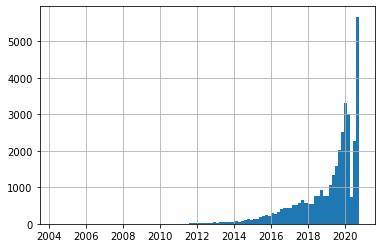

In [92]:
df.review_date_last.hist(bins=100)

In [93]:
df.review_date_last.min()

Timestamp('2004-04-21 00:00:00')

In [94]:
# Много ресторанов, без свежих отзывов

In [95]:
# Попытка убрать выбросы ухудшила прогноз
# Возможно стоит отфильтровать слишком старые
# df = df[df.review_date_last > datetime(2011, 6, 1)]
# df.review_date_last.hist(bins=100)

In [96]:
# Провал в 2020 году, возможно вызван ковидом

Разница между двумя отзывами

In [97]:
def reviews_diff(id_ta):
    """ Функция возвращает колчество дней между двумя последними отзывами """
    if id_ta in raw_data:
        match = re.findall(review_date_tmpl, raw_data[id_ta]['data']['review_date'])
        if len(match) > 1:
            delta = date_convert(match[0]) - date_convert(match[1])
            return delta.days
    return None

In [98]:
# Фиксируем разницу в днях между последними отзывами
df['reviews_date_diff'] = df.apply(lambda x: reviews_diff(x['id_ta']), 1)

In [99]:
# Пропуски заполняем меданой

In [100]:
reviews_delta_median = df.reviews_date_diff.median()

In [101]:
df['reviews_date_diff'] = df['reviews_date_diff'].fillna(reviews_delta_median)

<AxesSubplot:>

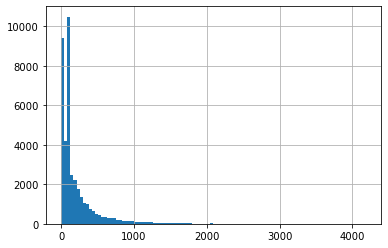

In [102]:
df.reviews_date_diff.hist(bins=100)

In [103]:
outliers_iqr(df.reviews_date_diff)

[-237.5, 518.5]

In [104]:
df = df[df.reviews_date_diff < 651]

<AxesSubplot:>

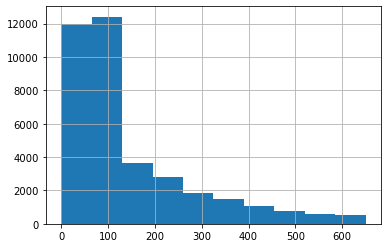

In [105]:
df.reviews_date_diff.hist()

In [106]:
today = datetime(2020, 10, 16)

In [107]:
def review_diff_now(date_review):
    """ Возвращает разницу последнего отзыва с настоящим временем, в днях """
    delta = today - date_review
    return delta.days

In [108]:
df['reviews_last_diff'] = df.apply(lambda x: review_diff_now(x['review_date_last']), 1)

In [109]:
df.reviews_last_diff = df.reviews_last_diff.fillna(df.reviews_last_diff.median())

<AxesSubplot:>

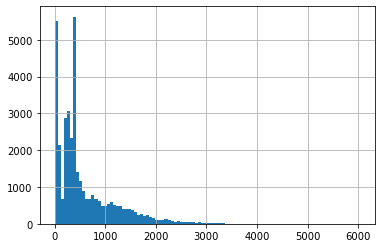

In [110]:
df.reviews_last_diff.hist(bins=100)

#### Ближайший важный объект

In [111]:
# На сайте есть информация о расстоянии до ближайшего важного объекта (здание, метро...). 

In [112]:
near_dist_tmpl = re.compile('div\W\Wb\W([\d\.\s]*)')

In [113]:
def near_dist(id_ta):
    if id_ta in raw_data:
        match = re.search(near_dist_tmpl, raw_data[id_ta]['data']['data_google'])
        if match:
            return float(match.group(1))
    return None

In [114]:
df['near_dist'] = df.apply(lambda x: near_dist(x['id_ta']), 1)

In [115]:
# Отсутствующие значения заполняем  медианой

In [116]:
near_dist_median = df.near_dist.median()

In [117]:
df.near_dist = df.near_dist.fillna(near_dist_median)

<AxesSubplot:>

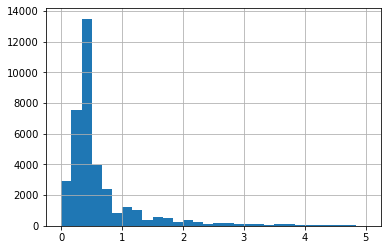

In [118]:
df.near_dist.hist(bins=30)

#### Все рестораны города

In [119]:
# С сайта можем получить дополнительный важный признак: количество ресторанов в городе

In [120]:
near_dist_tmpl = re.compile('of\s([\d\,]+)\sRestaurants')

In [121]:
def all_rest(id_ta):
    """ Возвращает количество ресторанов в городе"""
    if id_ta in raw_data:
        match = re.search(near_dist_tmpl, raw_data[id_ta]['data']['all_rest'])
        if match:
            return int(match.group(1).replace(',', ''))
    return None

In [122]:
df['all_rest'] = df.apply(lambda x: all_rest(x['id_ta']), 1)

In [123]:
# Пропуски заполняем медианой

In [124]:
all_rest_median = df.all_rest.median()

In [125]:
df.all_rest = df.all_rest.fillna(all_rest_median)

<AxesSubplot:>

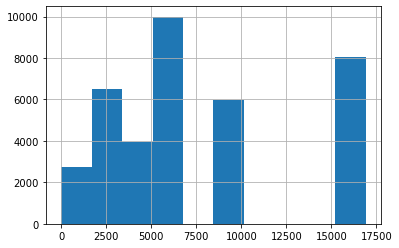

In [126]:
df.all_rest.hist()

In [127]:
df["rest_population"] = df.all_rest / df.population

In [128]:
# Мало признаков коррелирующие с целевой переменной. Но многие, лучше коррелируют с ranking. Надо добиваться лучшего результата.
df.corr()

,ranking,rating,number_of_reviews,population,capital,cuisine_num,price_range_upd,reviews_num_upd,reviews_date_diff,reviews_last_diff,near_dist,all_rest,rest_population
ranking,1.000000,-0.370531,-0.225062,0.557330,0.221780,-0.329220,-0.066410,-0.257023,0.068044,0.182905,0.044762,0.586972,-0.082366
rating,-0.370531,1.000000,0.029772,-0.037765,0.014934,0.127112,-0.016079,0.037401,-0.029496,-0.079456,-0.010277,-0.036835,0.036918
number_of_reviews,-0.225062,0.029772,1.000000,-0.008988,0.000187,0.384373,0.154375,0.974862,-0.170711,-0.239368,-0.126890,0.049773,-0.013044
population,0.557330,-0.037765,-0.008988,1.000000,0.411747,0.013802,0.009759,-0.010354,-0.083996,-0.097380,0.124979,0.627411,-0.103359
capital,0.221780,0.014934,0.000187,0.411747,1.000000,0.011864,0.022281,-0.003573,-0.033411,-0.040761,-0.002465,0.292104,0.064410
cuisine_num,-0.329220,0.127112,0.384373,0.013802,0.011864,1.000000,0.097206,0.446553,-0.202968,-0.380131,-0.102950,-0.022356,-0.008294
price_range_upd,-0.066410,-0.016079,0.154375,0.009759,0.022281,0.097206,1.000000,0.158144,-0.074595,-0.013421,-0.010003,0.015246,-0.018383
reviews_num_upd,-0.257023,0.037401,0.974862,-0.010354,-0.003573,0.446553,0.158144,1.000000,-0.197429,-0.294172,-0.141129,0.055456,-0.011234
reviews_date_diff,0.068044,-0.029496,-0.170711,-0.083996,-0.033411,-0.202968,-0.074595,-0.197429,1.000000,0.084065,0.077355,-0.046433,-0.008626
reviews_last_diff,0.182905,-0.079456,-0.239368,-0.097380,-0.040761,-0.380131,-0.013421,-0.294172,0.084065,1.000000,0.078960,-0.035531,-0.010703


In [129]:
# Сформируем dummy признаки по странам
data_with_dummies_cntr = pd.get_dummies(df, columns=['country'], dtype=float)

In [130]:
# Попробуем сократить число значений в городах.

In [131]:
# cities_freq = list(data_with_dummies_cntr.city.value_counts())
# top_cities_count = int(np.percentile(cities_freq, 90))
# top_cities_count

In [132]:
all_cities = data_with_dummies_cntr.city.value_counts().index

In [133]:
# Возьмем 28, остальные в Other (параметр подобран экспериментально)
top_cities = list(all_cities)[:28]

In [134]:
# Список на выбывание
cities_to_throw_away = list(set(all_cities)-set(top_cities))

In [135]:
# Сокращаем города
data_with_dummies_cntr.loc[data_with_dummies_cntr['city'].isin(cities_to_throw_away), 'city'] = 'Other'

In [136]:
# Осталось 28 городо + Other
len(data_with_dummies_cntr.city.value_counts())

29

In [137]:
# Создаем dummy переменные
data_with_dummies = pd.get_dummies(data_with_dummies_cntr, columns=['city'], dtype=float)

In [138]:
data_with_dummies = data_with_dummies.drop(['restaurant_id', 'cuisine_style', 'number_of_reviews', 'price_range', 'reviews', 'url_ta', 
              'id_ta', 'cuisine_list', 'review_date_last'], axis=1)

In [139]:
# С этим признаком, результат хуже. Пока закомментируем.
# data_with_dummies = data_with_dummies.drop('population', axis=1)

In [140]:
# Нормализация признаков

In [141]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [142]:
for col in data_with_dummies.columns:
    if col not in ['rating']:
        data_with_dummies[col] = scaler.fit_transform(pd.DataFrame(data_with_dummies[col]))

<AxesSubplot:>

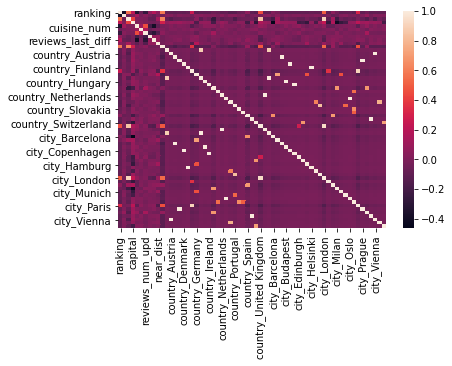

In [143]:
sns.heatmap(data_with_dummies.corr(method="pearson"))

In [144]:
# Поиск выбросов с помощью DBSCAN (пока в тесте)

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

db = DBSCAN(eps=0.5, min_samples=10).fit(np.reshape(np.array(df.reviews_last_diff), (-1, 1)))
print(len(np.where(db.labels_ == -1)[0]))

np.where(db.labels_ == -1)[0]

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [145]:
X = data_with_dummies.drop(['rating'], axis = 1)
y = data_with_dummies['rating']

In [146]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [147]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [148]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [149]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [150]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2284186746987952


In [151]:
import matplotlib as plt

<AxesSubplot:>

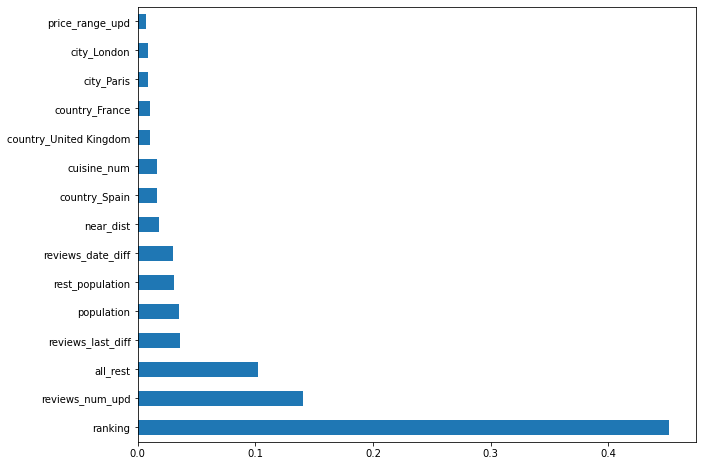

In [152]:
# Проверим важные признаки данной модели
plt.rcParams['figure.figsize'] = (10,8)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Координаты ресторана (можно определить удаленность от центра)

In [153]:
# Не успел

In [154]:
import base64

In [155]:
near_dist_tmpl = re.compile('data-encoded-url="([\w\/\d]*)\"')
match = re.search(near_dist_tmpl, raw_data['d12503536']['data']['data_google'])
if match:
    encoded_url = match.group(1)
    decoded_url = base64.b64decode(encoded_url)
    new_match = re.findall('\@([\-\d\.]+),([\-\d\.]+)_', str(decoded_url))
    if len(new_match) > 0:
        lat = new_match[0][0]
        lon = new_match[0][1]
        print(lat, lon)    

41.13378 -8.613067
